In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

public_kwh = APT - month_df['usage (kWh)'].sum()
public_kwh

In [4]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


## 문서화 공간

### TimeDivision KMeans Fitting

ECV : 39%


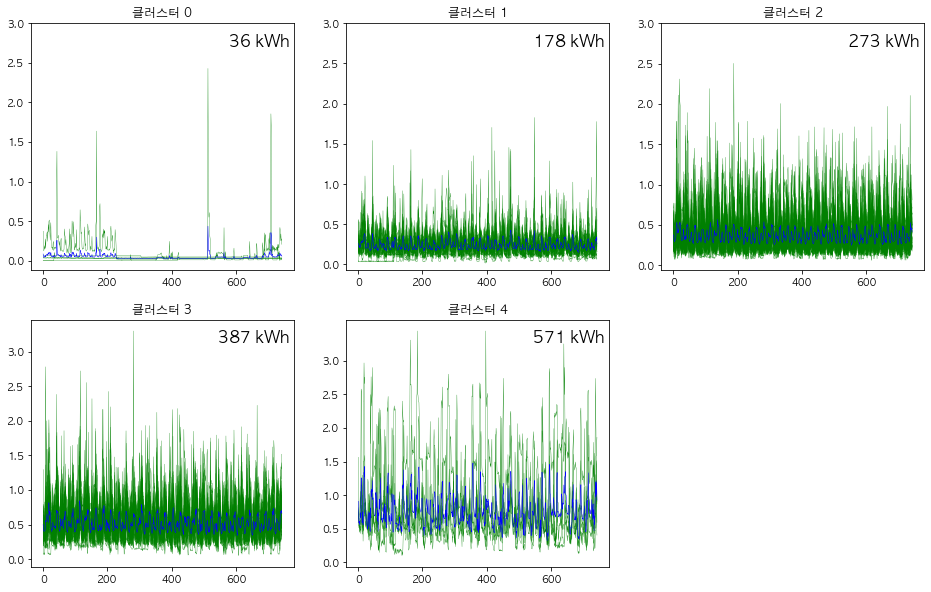

In [80]:
from src import SavingFeedback

sf = SavingFeedback(xlsx, _type="tdkmeans")

sf.select_month(1)
sf.kmeans_run()

clear_output(wait=True)
print("ECV : {}%".format(round(sf.kmeans.kmeans.ecv * 100)))

sf.kmeans.draw_plot()

이상패턴 조정 확인 True
ECV : 39%


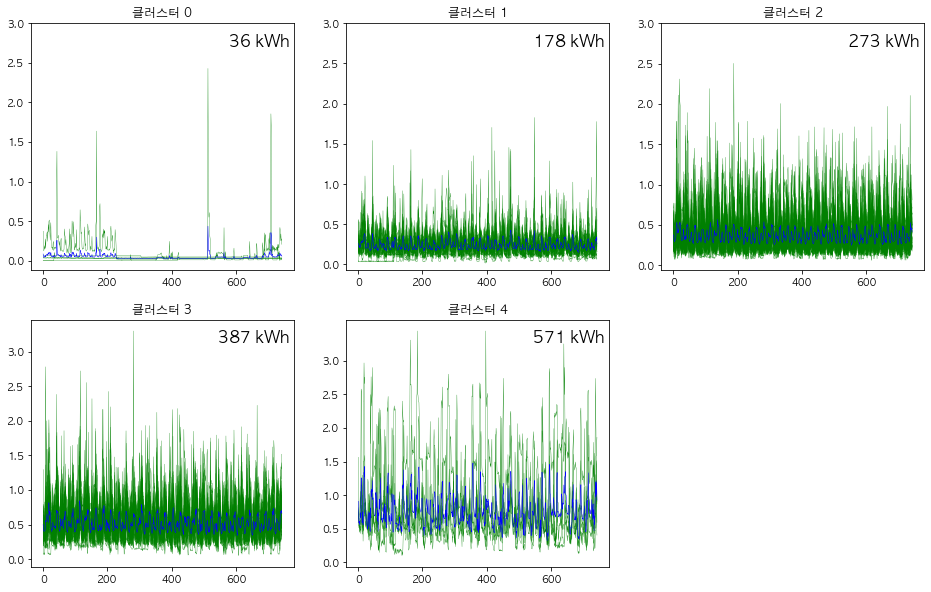

In [81]:
sf.adjust_anomaly()

anomaly = sf.check_anomaly()
clear_output(wait=True)
print("이상패턴 조정 확인", len(anomaly) == 0)
print("ECV : {}%".format(round(sf.kmeans.kmeans.ecv * 100)))

sf.kmeans.draw_plot()

### Cluster Contribution Table

In [82]:
cluster_info = sf.kmeans.cluster_info.copy()
cluster_info.reset_index(inplace=True, drop=True)
cluster_info.index = m_60_1.index[::3]

cluster_info[cluster_info.columns[:8]].head(10)

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402
2019-01-01 00:00:00,0,0,0,0,0,1,2,3
2019-01-01 03:00:00,0,0,0,0,0,1,3,3
2019-01-01 06:00:00,0,0,0,0,0,1,1,1
2019-01-01 09:00:00,0,0,0,0,0,0,0,1
2019-01-01 12:00:00,0,0,0,0,0,1,0,1
2019-01-01 15:00:00,0,0,0,0,0,1,1,0
2019-01-01 18:00:00,0,0,0,0,0,1,2,1
2019-01-01 21:00:00,0,0,0,0,0,1,2,3
2019-01-02 00:00:00,0,0,0,0,0,1,1,3
2019-01-02 03:00:00,0,0,0,0,0,1,1,1


In [83]:
sf.kmeans.cluster_cont_table_

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 2., 1., ..., 1., 1., 1.],
       [3., 2., 2., ..., 2., 2., 1.],
       [3., 4., 3., ..., 3., 3., 2.],
       [4., 6., 4., ..., 3., 4., 4.]])

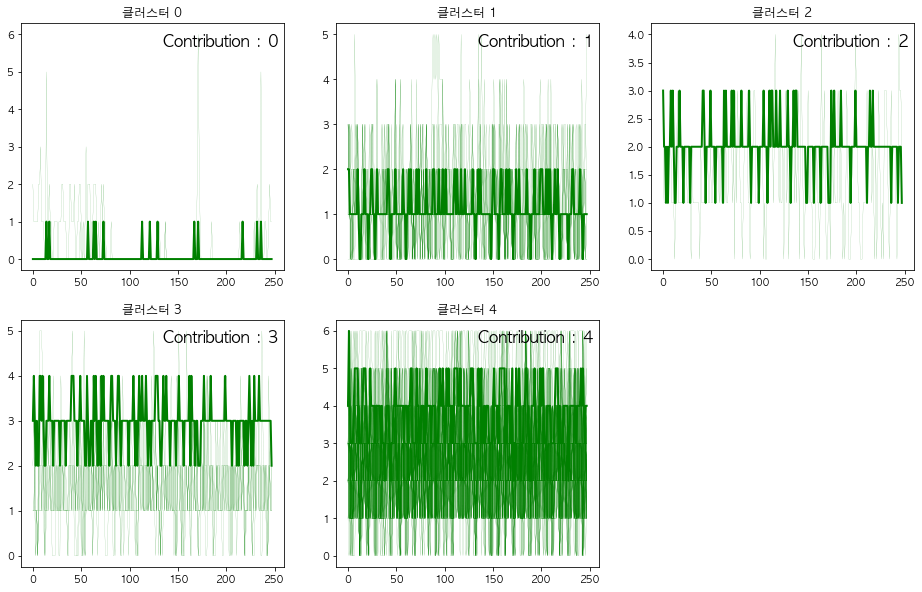

In [84]:
sf.kmeans.draw_cont_plot()

## Contribution Based Comparing

In [56]:
import datetime as dt

time_size = 3

start_time = 3
end_time = start_time + time_size

start_time = dt.time(start_time, 0)
end_time = dt.time(end_time, 0)
sum_df = m_60_1[(m_60_1.index.time >= start_time) &
            (m_60_1.index.time < end_time)]

test_df = pd.DataFrame(np.column_stack([
    m_60_1.columns,
    sum_df.mean(axis=0).values,
    cluster_info[cluster_info.index.time == start_time].mean(axis=0)]),
                      columns=['name', 'usage (kWh)', '평균 기여도'])

test_df

,name,usage (kWh),평균 기여도
0,아파트1-104-1206,0.10272,0.870968
1,아파트1-104-303,0.012204,0.032258
2,아파트1-104-1307,0.030108,0.225806
3,아파트1-104-1208,0.048645,0.322581
4,아파트1-104-408,0.052108,0.290323
...,...,...,...
103,아파트1-103-903,0.322409,2.709677
104,아파트1-103-1106,0.241516,1.935484
105,아파트1-103-705,0.239323,2.032258
106,아파트1-103-1505,0.331269,2.806452


In [57]:
anal_df = pd.DataFrame()
for cont_offset in np.arange(0.5, 2, 0.25):
    mins = list()
    for idx,row in test_df.iterrows():
        cont = row['평균 기여도']
        kwh = row['usage (kWh)']
        upper_cont = cont + cont_offset

        _min = test_df[test_df['평균 기여도'] > upper_cont]['usage (kWh)'].min()

        if ~np.isnan(_min):
            _err = _min - kwh
            mins.append(_err)

    anal_df[cont_offset] = [np.array(mins).min()]
    
anal_df = anal_df.T
anal_df.std()

0    0.053896
dtype: float64

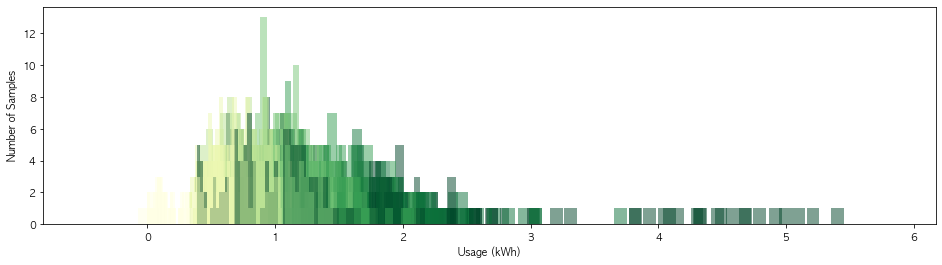

In [58]:
sf.kmeans.hist(division_slot=0)

## 시간대 피드백 시나리오

In [59]:
time_size = 3

sf.time_based_grouping(time_size)
sf.feedback(td_limit=0.5)

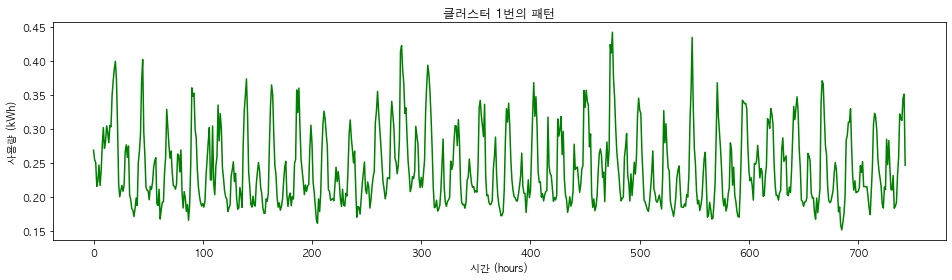

In [60]:
plt.figure(figsize=(16,4))

plt.plot(sf.kmeans.clusters_[1], color='g')
plt.title("클러스터 1번의 패턴")
plt.ylabel("사용량 (kWh)")
plt.xlabel("시간 (hours)")

plt.show()

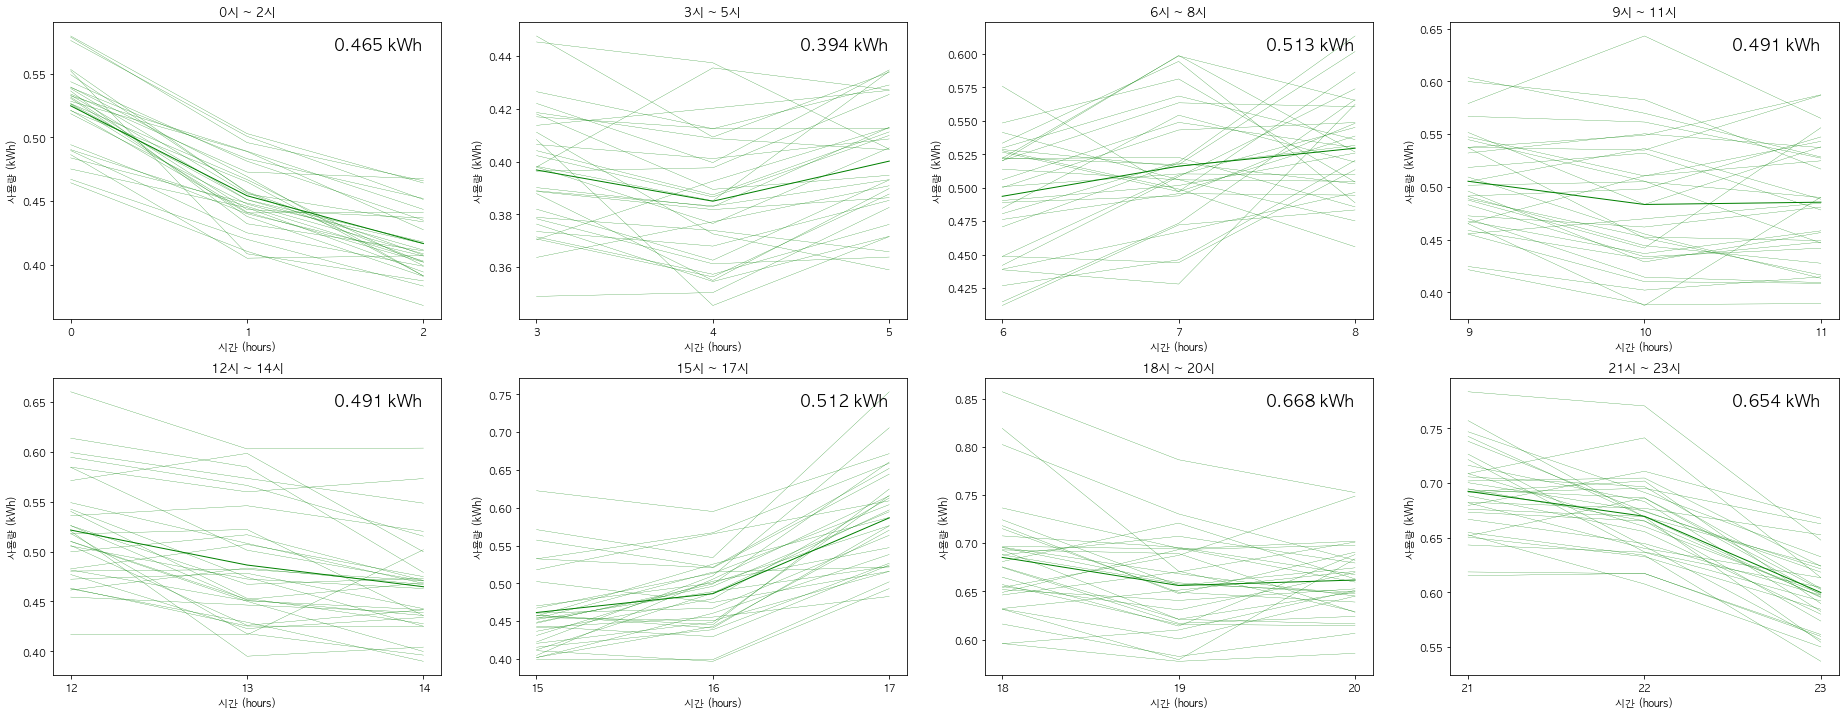

In [61]:
times = [(start_time, start_time + (time_size-1))
             for start_time in range(0, 24, time_size)]
plt.figure(figsize=(32, 12))

for idx, group in enumerate(sf.clusters_[3][0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 4, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간 (hours)")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [62]:
sf.kmeans.target_cluster_cont_

array([[0.09677419, 0.29032258, 0.        , 0.03225806, 0.03225806,
        0.        , 0.06451613, 0.06451613],
       [1.25806452, 1.64516129, 1.06451613, 0.90322581, 0.77419355,
        0.93548387, 1.16129032, 1.19354839],
       [2.19354839, 2.29032258, 2.03225806, 1.87096774, 1.80645161,
        1.87096774, 1.93548387, 2.16129032],
       [3.29032258, 3.35483871, 2.93548387, 2.70967742, 2.77419355,
        2.87096774, 2.80645161, 3.22580645],
       [4.35483871, 4.48387097, 4.06451613, 3.51612903, 3.29032258,
        3.29032258, 3.83870968, 4.29032258]])

             name usage (kWh)  label
11  아파트1-103-1602         387      3


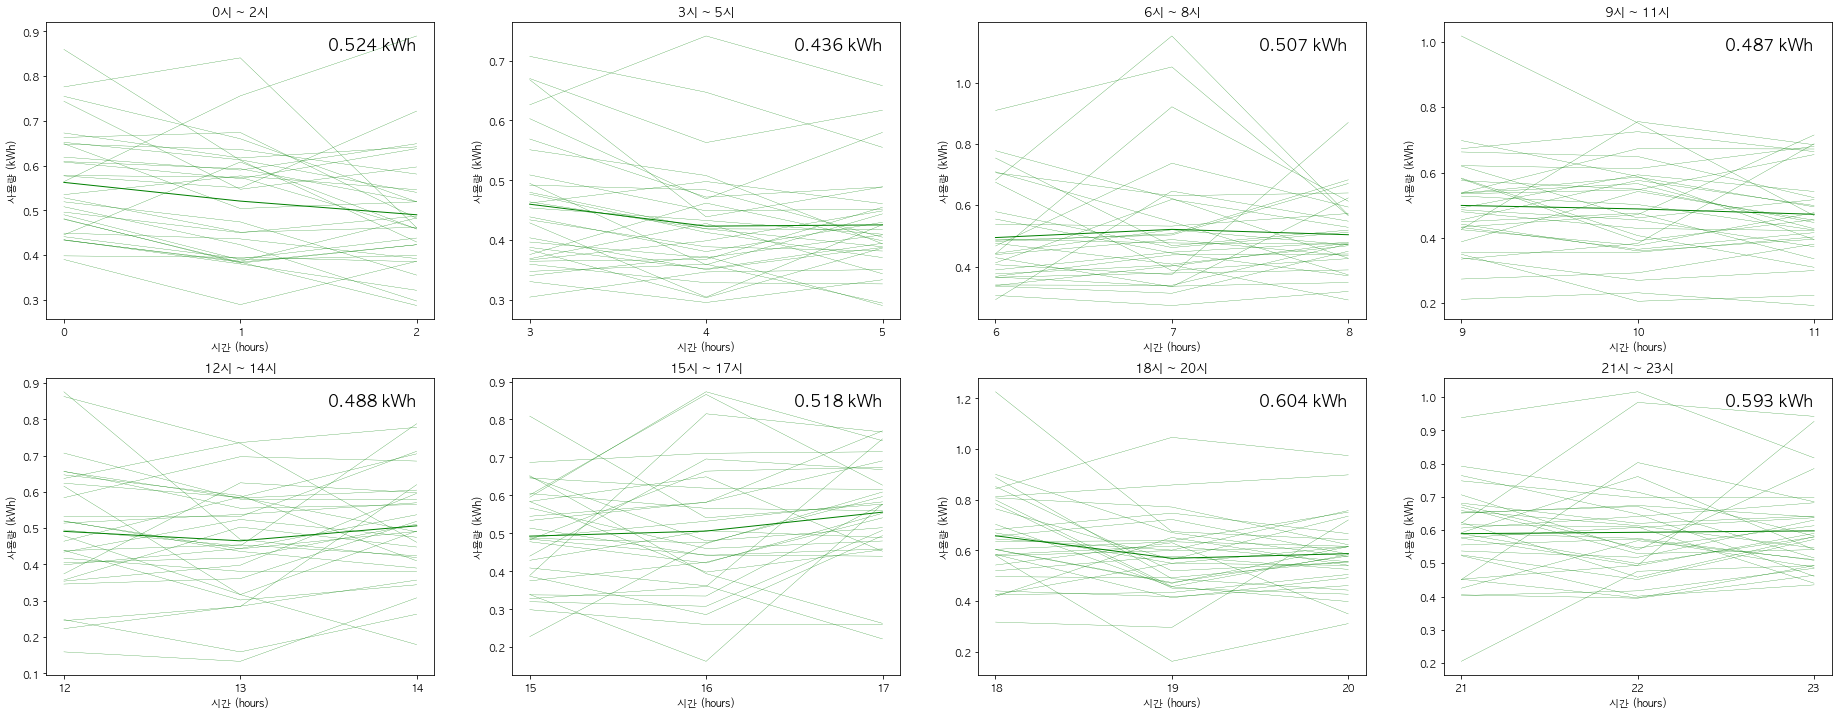

In [63]:
name = '아파트1-103-1602'

target_house = sf.group[sf.group['name'] == name]
print(target_house)
target_pattern = sf.datas[name].values
t_tg = sf.time_grouping(target_pattern, time_size)
idx = sf.group[sf.group['name'] == name].index[0]

times = [(start_time, start_time + (time_size-1))
             for start_time in range(0, 24, time_size)]
plt.figure(figsize=(32, 12))

for idx, group in enumerate(t_tg[0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 4, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간 (hours)")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [64]:
idx = sf.group[sf.group['name'] == name].index[0]

sf.kmeans.target_cont_[idx]

array([3.80645161, 3.70967742, 3.09677419, 2.83870968, 2.70967742,
       3.12903226, 2.5483871 , 3.03225806])

가구 명 : 아파트1-103-1602


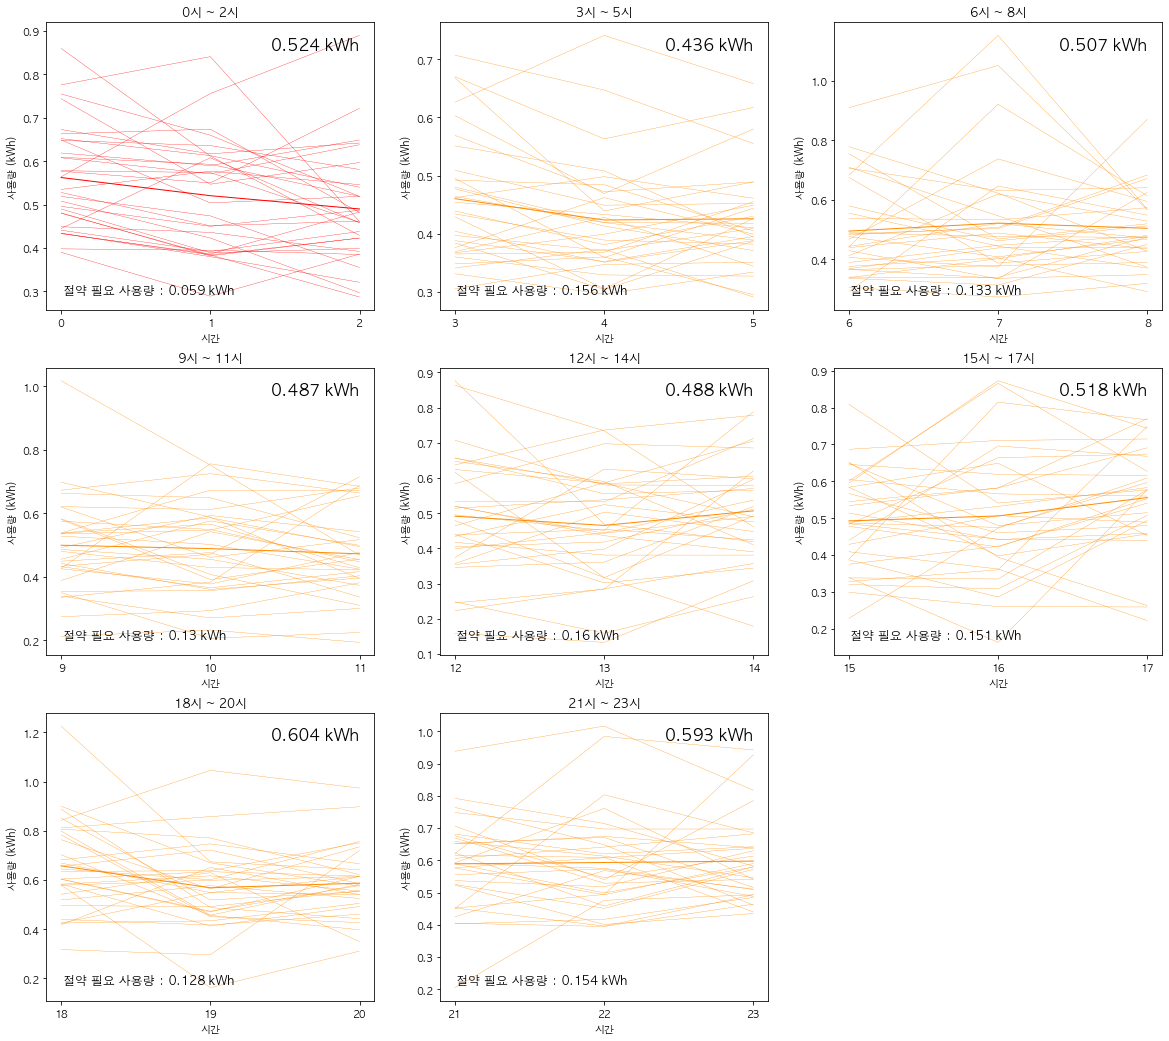

In [65]:
draw = sf.draw_init(name)

draw.house()

In [66]:
sf.recovery()
sf.result()

og_pat = sf.datas.values.T
rec_pat = sf.recoveries
err = (og_pat - rec_pat)
err[err != 0].min()

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 744) (108, 744)
최소 오차 0.018000000000000002


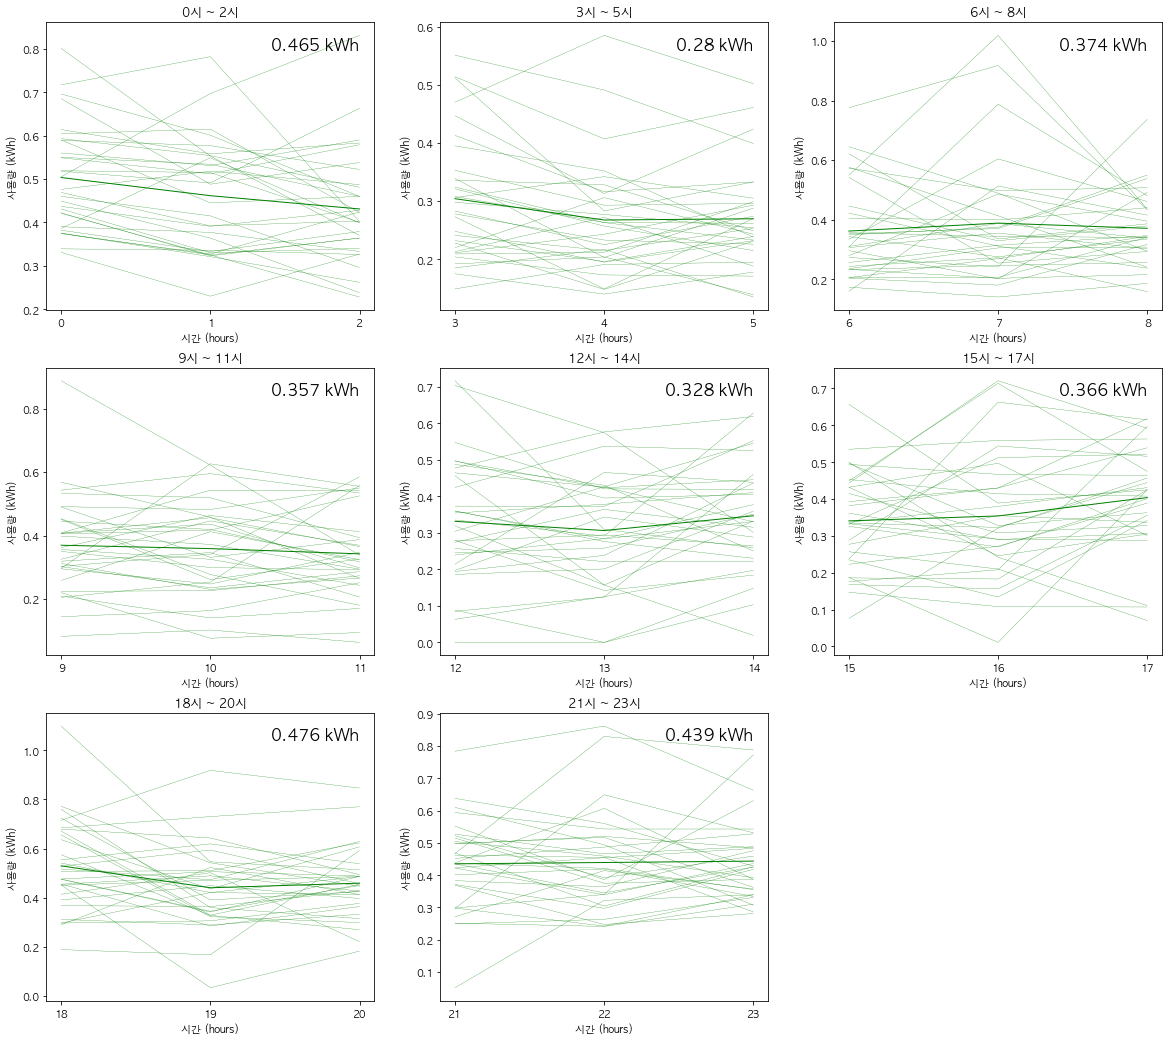

In [67]:
idx = sf.group[sf.group['name'] == name].index[0]
t_tg = sf.time_grouping(rec_pat[idx], time_size)

times = [(start_time, start_time + (time_size-1))
             for start_time in range(0, 24, time_size)]
plt.figure(figsize=(20, 18))

for idx, group in enumerate(t_tg[0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간 (hours)")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [68]:
_APT = sf.new_group['usage (kWh)'].sum() + public_kwh
_APT

after_calc = crs.models.ManagementOffice(
        month=_month,
        households=sf.new_group,
        APT=_APT,
        contract="단일계약"
    )

print("original", calc.households[month_df[month_df['name'] == name].index[0]].elec_bill)
print("new", after_calc.households[sf.new_group[sf.new_group['name'] == name].index[0]].elec_bill)

original 43420
new 28960


In [69]:
calc.households[month_df[month_df['name'] == name].index[0]].kwh

387

In [70]:
after_calc.households[sf.new_group[sf.new_group['name'] == name].index[0]].kwh

287

## 요일별 피드백 시나리오

In [156]:
sf.day_based_grouping()
sf.feedback(td_limit=0.4)

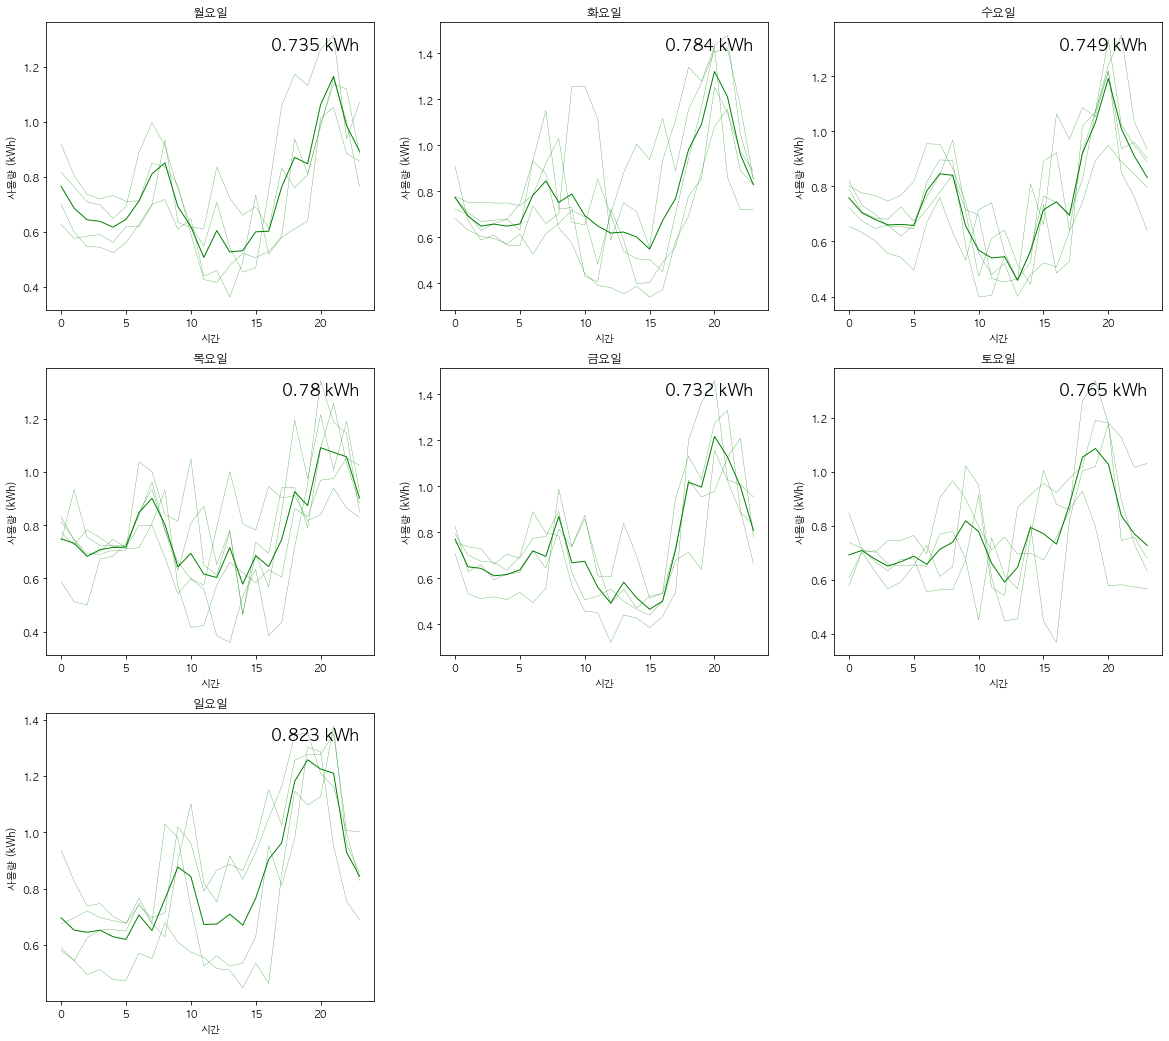

In [157]:
# 현재 자신이 속해 있는 기여도 그룹 현황
plt.figure(figsize=(20, 18))

for idx, group in enumerate(sf.clusters_[4][0]):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.25)
    ax.plot(mean_group, color='g', linewidth=1)
    ax.set_title("{}요일".format(day))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [158]:
sf.kmeans.target_cluster_cont_

array([[0.0625 , 0.1    , 0.125  , 0.075  , 0.     , 0.     , 0.     ],
       [1.15625, 1.1    , 1.125  , 1.05   , 1.1875 , 1.25   , 1.15625],
       [2.03125, 2.     , 2.075  , 2.025  , 2.0625 , 1.9375 , 1.96875],
       [2.9375 , 2.875  , 3.05   , 3.025  , 3.03125, 2.96875, 2.9375 ],
       [4.03125, 3.85   , 3.875  , 3.875  , 3.875  , 3.625  , 3.8125 ]])

In [159]:
sf.group.sample(n=1)['name']

61    아파트1-103-1604
Name: name, dtype: object

            name usage (kWh)  label
35  아파트1-101-704         473      4


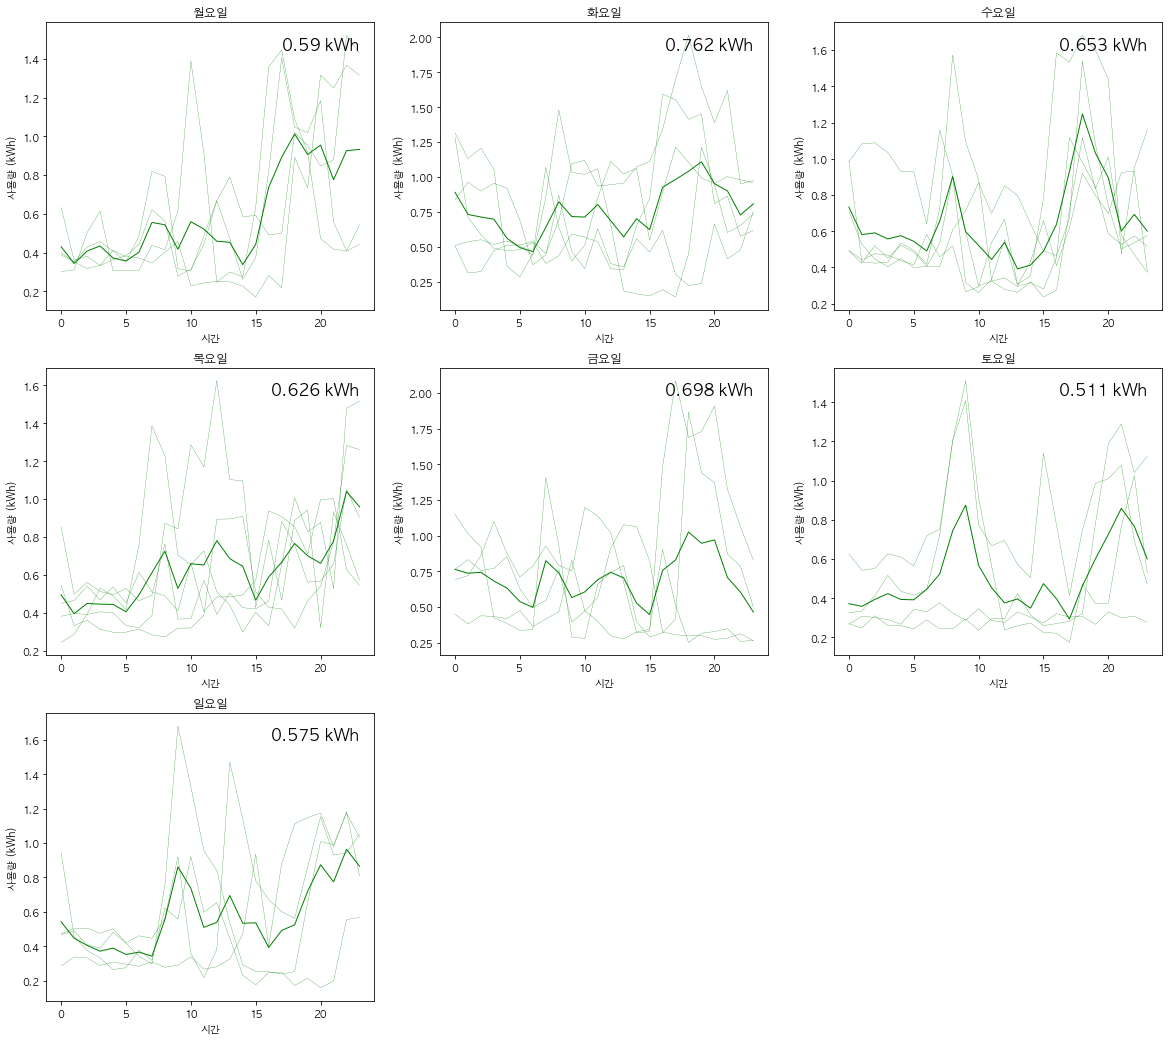

In [168]:
# name = sf.group.sample(n=1)['name'].values[0]
name = "아파트1-101-704"

target_house = sf.group[sf.group['name'] == name]
print(target_house)
target_pattern = sf.datas[name].values
t_tg = sf.day_grouping(target_pattern)
idx = sf.group[sf.group['name'] == name].index[0]

plt.figure(figsize=(20, 18))

for idx, group in enumerate(t_tg[0]):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.25)
    ax.plot(mean_group, color='g', linewidth=1)
    ax.set_title("{}요일".format(day))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [174]:
idx = sf.group[sf.group['name'] == name].index[0]

sf.kmeans.target_cont_[idx]

array([3.28125, 3.7, 3.675, 3.55, 3.78125, 2.5625, 3.03125], dtype=object)

가구 명 : 아파트1-101-704


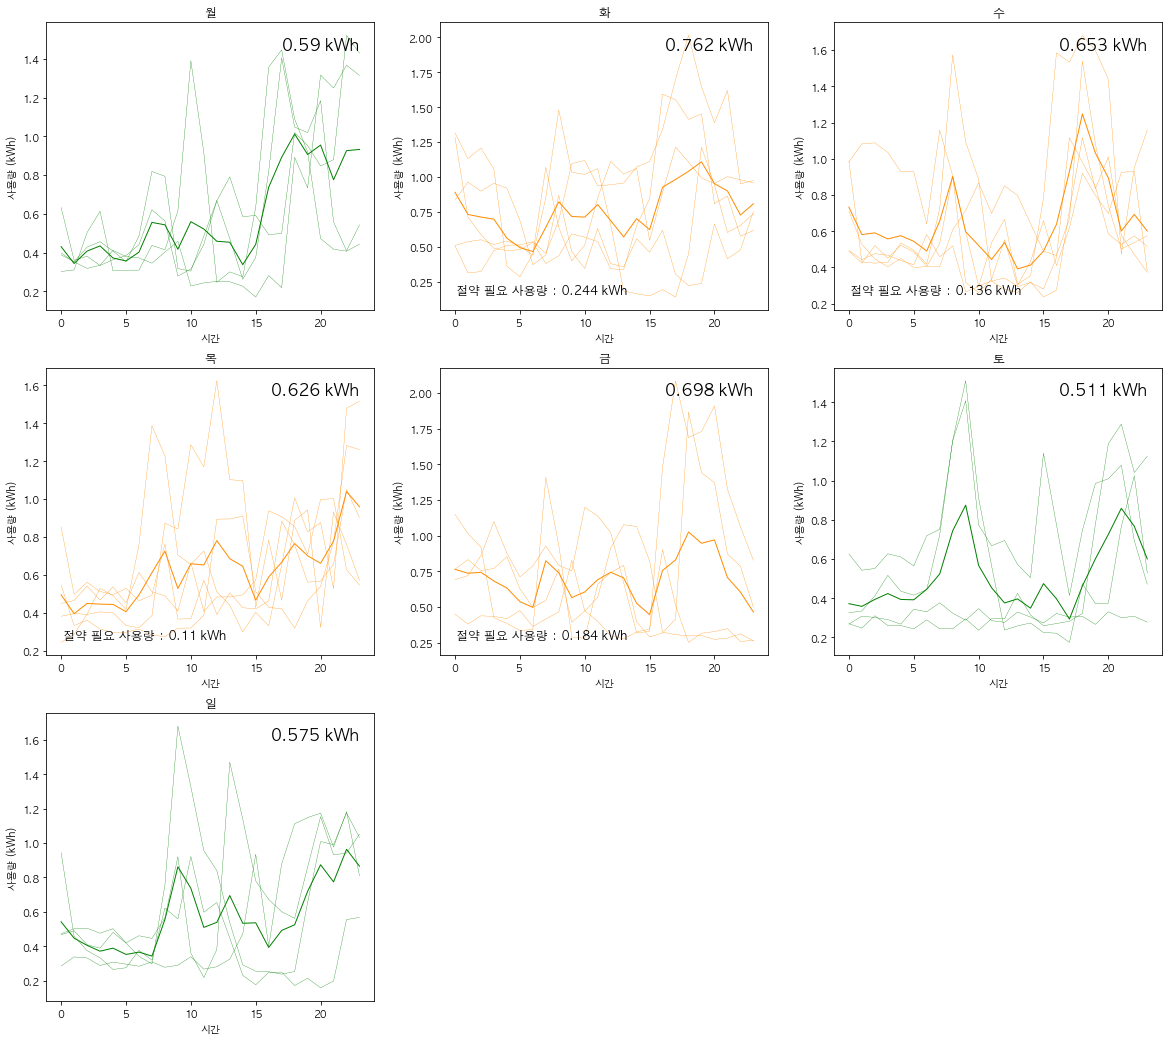

In [175]:
draw = sf.draw_init(name)

draw.house()

In [176]:
sf.recovery()
sf.result()

og_pat = sf.datas.values.T
rec_pat = sf.recoveries
err = (og_pat - rec_pat)
err[err != 0].min()

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 744) (108, 744)
최소 오차 0.018000000000000002


In [177]:
t_tg = sf.day_grouping(rec_pat[idx])

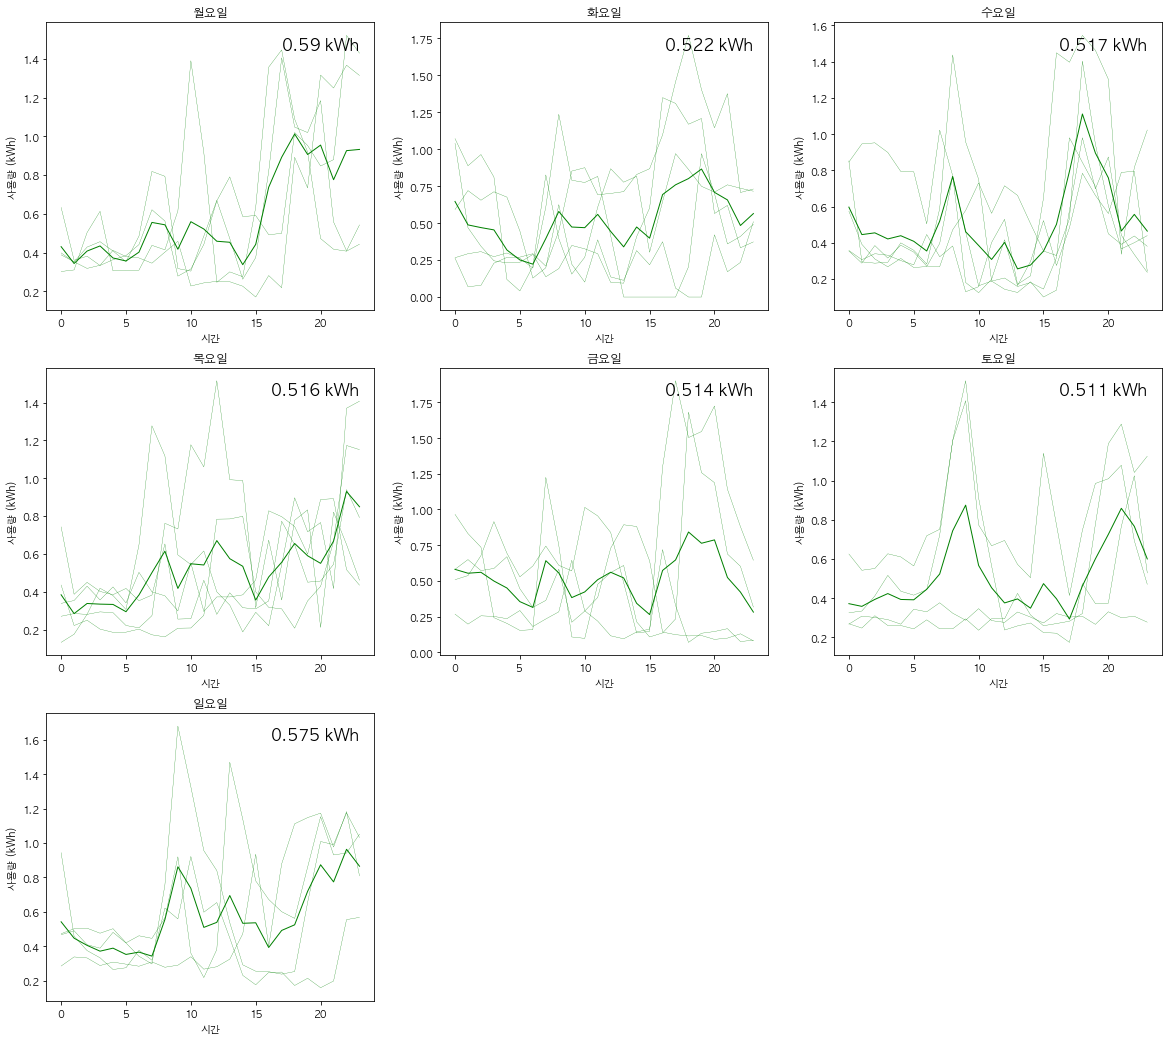

In [178]:
# 현재 자신이 속해 있는 기여도 그룹 현황
plt.figure(figsize=(20, 18))

for idx, group in enumerate(t_tg[0]):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.25)
    ax.plot(mean_group, color='g', linewidth=1)
    ax.set_title("{}요일".format(day))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [192]:
print(sf.new_group[sf.group['name'] == '아파트1-101-704'])
print(sf.new_group[sf.new_group['name'] == '아파트1-101-704'])

            name  usage (kWh)  label
35  아파트1-101-704          397      4
            name  usage (kWh)  label
35  아파트1-101-704          397      4


In [193]:
_APT = sf.new_group['usage (kWh)'].sum() + public_kwh
_APT

after_calc = crs.models.ManagementOffice(
        month=_month,
        households=sf.new_group,
        APT=_APT,
        contract="단일계약"
    )

print("original", calc.households[month_df[month_df['name'] == name].index[0]].elec_bill)
print("new", after_calc.households[sf.new_group[sf.new_group['name'] == name].index[0]].elec_bill)

original 65640
new 44866
